In [28]:
import sklearn
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from functools import partial

# Initial load and drop irrelevant files.

Creates a function to go from location_key to the real county name

In [29]:
df = pd.read_csv("../../data/usa_covid_all.csv")
# df = pd.read_csv("../../data/usa_covid_gt20.csv")
#date
df['date'] = pd.to_datetime(df['date'])

#remove unrelated features
df = df.drop(columns=['aggregation_level','latitude','longitude','openstreetmap_id','location_geometry','datacommons_id','wikidata_id','iso_3166_1_alpha_2','iso_3166_1_alpha_3'])

#drop country and per state rows
df = df.dropna(axis='index', subset=['subregion2_code'])

#remove location names and make map
df = df.astype({'subregion2_code':int})
names = df[['subregion1_name','subregion2_name','subregion2_code']].drop_duplicates(subset=['subregion2_code'])
def codeNameConverter(code, names):
    if isinstance(code, str):
        code = int(code.split("_")[2])
    res = names[names['subregion2_code'] == code]
    return f"{res.iloc[0]['subregion2_name']}, {res.iloc[0]['subregion1_name']}"
codeToName = partial(codeNameConverter, names=names)
df = df.drop(columns=['country_code', 'country_name','subregion1_code','subregion1_name','subregion2_code','subregion2_name'])



# Clean data and interpolate columns where required

Make sure no values are missing

In [30]:
#imputations!
#assume nan for rain and snow means 0
df['rainfall_mm'].fillna(0,inplace=True)
df['snowfall_mm'].fillna(0,inplace=True)

#interpolate missing temperatures, can't remove as there are some days with covid cases
df['average_temperature_celsius'] = df['average_temperature_celsius'].interpolate()
df['minimum_temperature_celsius'] = df['minimum_temperature_celsius'].interpolate()
df['maximum_temperature_celsius'] = df['maximum_temperature_celsius'].interpolate()

#fill mobility reports with 0 for na since its a relative % to baseline
df['mobility_transit_stations'] = df['mobility_transit_stations'].interpolate()
df['mobility_retail_and_recreation'] = df['mobility_retail_and_recreation'].interpolate()
df['mobility_grocery_and_pharmacy'] = df['mobility_grocery_and_pharmacy'].interpolate()
df['mobility_residential'] = df['mobility_residential'].interpolate()
df['mobility_parks'] = df['mobility_parks'].interpolate()
df['mobility_workplaces	'] = df['mobility_workplaces'].interpolate()

#drop columns with too many nan (that we couldnt impute)
df = df.dropna(thresh=len(df)*.3,axis=1)

df = df.fillna(0)

In [31]:
df.describe()

,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,mobility_workplaces\t
count,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000,951375.000000
mean,8.618745,0.224647,791.342200,27.155887,-6.162114,-9.713561,0.323436,14.818107,5.098840,-14.103336,15.374502,9.809420,21.896448,2.204424,7.493467,-20.421942
std,57.353023,2.430024,4966.788023,199.114861,21.200312,19.563723,13.534179,45.545136,4.784366,16.313139,9.915181,9.976389,10.249489,5.598102,44.016265,14.338580
min,-2321.000000,-512.000000,0.000000,0.000000,-92.000000,-100.000000,-96.000000,-91.000000,-46.000000,-92.000000,-41.569444,-44.927778,-37.746914,0.000000,0.000000,-92.000000
25%,0.000000,0.000000,0.000000,0.000000,-17.894231,-21.000000,-6.979592,-14.537290,2.000000,-27.000000,8.255556,2.416667,15.005556,0.000000,0.000000,-29.000000
50%,0.000000,0.000000,21.000000,0.000000,-3.714286,-7.000000,-0.289017,8.222426,4.000000,-9.000000,17.243056,10.911111,24.338889,0.084667,0.000000,-20.075472
75%,3.000000,0.000000,233.000000,4.000000,6.925331,2.187755,6.166667,35.556300,7.000000,0.000000,23.644444,18.049383,30.155556,1.741714,0.000000,-10.140002
max,14129.000000,455.000000,289366.000000,6877.000000,222.000000,261.000000,225.000000,709.000000,38.000000,66.000000,39.833333,32.550000,47.736111,196.342000,1750.060000,66.000000


In [32]:
df.count()

date                              951375
location_key                      951375
new_confirmed                     951375
new_deceased                      951375
cumulative_confirmed              951375
cumulative_deceased               951375
mobility_transit_stations         951375
mobility_retail_and_recreation    951375
mobility_grocery_and_pharmacy     951375
mobility_parks                    951375
mobility_residential              951375
mobility_workplaces               951375
average_temperature_celsius       951375
minimum_temperature_celsius       951375
maximum_temperature_celsius       951375
rainfall_mm                       951375
snowfall_mm                       951375
mobility_workplaces\t             951375
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951375 entries, 0 to 969074
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   date                            951375 non-null  datetime64[ns]
 1   location_key                    951375 non-null  object        
 2   new_confirmed                   951375 non-null  float64       
 3   new_deceased                    951375 non-null  float64       
 4   cumulative_confirmed            951375 non-null  float64       
 5   cumulative_deceased             951375 non-null  float64       
 6   mobility_transit_stations       951375 non-null  float64       
 7   mobility_retail_and_recreation  951375 non-null  float64       
 8   mobility_grocery_and_pharmacy   951375 non-null  float64       
 9   mobility_parks                  951375 non-null  float64       
 10  mobility_residential            951375 non-null  float64

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

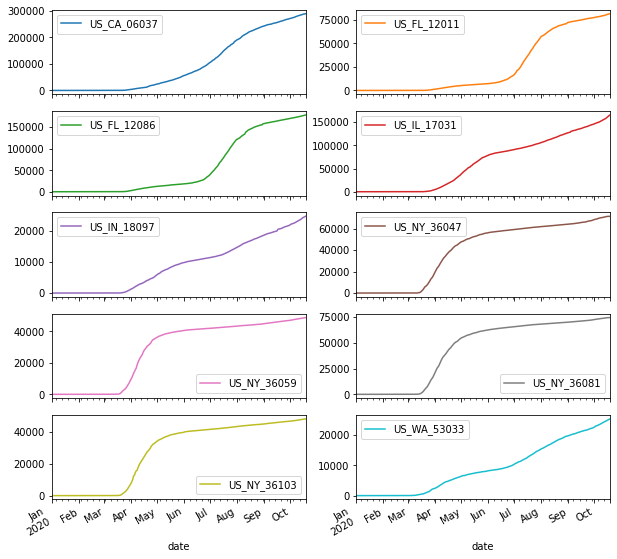

In [36]:
# grouped = df_filt.groupby(['location_key']).filter(lambda x : x['new_confirmed'].count() > 200)
top10=df[df['new_confirmed']>25].groupby('location_key').agg({'date' : np.size}).sort_values('date',ascending=False)[0:10]
df_filt = df[df['location_key'].isin(top10.index)].fillna(0)

majorcounties = df_filt.pivot(index="date",columns="location_key", values="cumulative_confirmed")
majorcounties = majorcounties.drop(majorcounties.tail(2).index)

majorcounties.plot(subplots=True,layout=(5,2),figsize=(10,10))

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

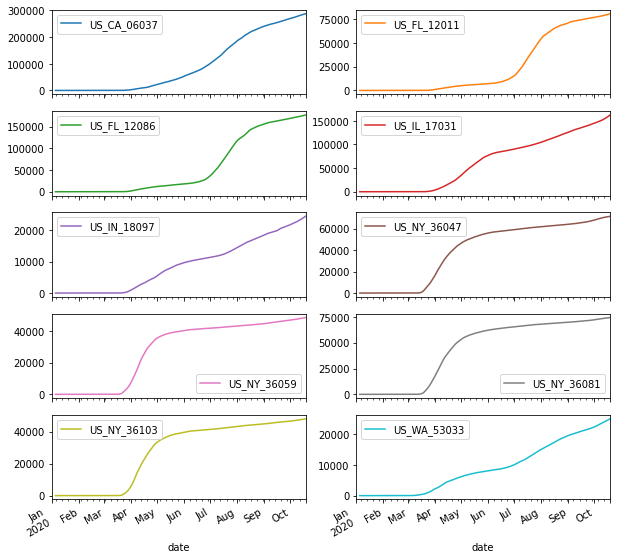

In [35]:
majorcounties_smth = majorcounties.rolling(5).mean()
majorcounties_smth.plot(subplots=True,layout=(5,2),figsize=(10,10))